# 데이터 사이언스 최종 과제 
### 컴퓨터공학과 
### 202130422 박연수 

### train.csv   
주어진 훈련 데이터는 store_nbr, family, onpromotion이라는 특징들의 시계열과 목표 변수인 sales로 구성됩니다.   

- store_nbr: 제품이 판매된 매장을 식별합니다.   
- family: 판매된 제품의 종류를 식별합니다.   
- sales: 특정 날짜에 특정 매장에서 제품군의 총 판매량을 나타냅니다. 제품이 분수 단위로 판매될 수 있기 때문에, 판매량은 소수 값일 수도 있습니다(예: 치즈 1.5kg 또는 감자칩 1봉지).   
- onpromotion: 특정 날짜에 특정 매장에서 특정 제품군의 프로모션 중인 아이템 수를 나타냅니다.   

### test.csv
테스트 데이터는 훈련 데이터와 동일한 특징을 가지고 있습니다. 이 파일에 있는 날짜에 대해 목표 판매량(sales)을 예측해야 합니다. 테스트 데이터의 날짜는 훈련 데이터의 마지막 날짜 이후 15일 동안의 날짜를 포함합니다.

### sample_submission.csv
올바른 형식의 샘플 제출 파일입니다.

### stores.csv
도시, 주(state), 유형(type), 클러스터(cluster)를 포함한 매장 메타데이터입니다. 클러스터는 유사한 매장들의 그룹을 나타냅니다.

### oil.csv
일별 유가를 나타냅니다. 훈련 데이터와 테스트 데이터 기간 동안의 유가를 포함합니다. 에콰도르는 석유 의존 국가이므로, 유가 충격에 경제적으로 매우 취약합니다.

### holidays_events.csv
휴일 및 이벤트에 대한 메타데이터를 포함하고 있습니다.   

참고: transferred 열에 특히 주의해야 합니다.    
공식적으로 휴일이 해당 날짜에 있지만 정부에 의해 다른 날짜로 이동된 경우, transferred 열이 표시됩니다. 이 경우, 해당 날짜는 일반 평일과 비슷합니다.   
실제로 축하된 날짜를 찾으려면, type이 Transfer인 행을 찾아보세요. 예를 들어, Independencia de Guayaquil 휴일은 2012-10-09에서 2012-10-12로 이동되었습니다.   
이는 2012-10-12에 축하되었음을 의미합니다. Bridge 유형은 휴일에 추가되는 추가 날짜를 나타내며, 자주 Work Day 유형으로 보상됩니다.      
Work Day는 일반적으로 근무하지 않는 날(예: 토요일)을 나타내며, Bridge를 보상하기 위해 사용됩니다.    
추가 휴일은 정규 달력 휴일에 추가되는 날을 의미하며, 예를 들어, 크리스마스 주위에 자주 발생합니다(크리스마스 이브를 휴일로 만드는 경우).      
이 정보를 바탕으로 테스트 데이터에 대해 예측을 수행하고, 결과를 제출 파일 형식에 맞추어 제출해야 합니다.      

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler


df_holi = pd.read_csv('data/holidays_events.csv')
df_oil = pd.read_csv('data/oil.csv')
df_stores = pd.read_csv('data/stores.csv')
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')
df_transactions = pd.read_csv('data/transactions.csv')

test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
transactions = pd.read_csv('data/transactions.csv') 

In [66]:
def EDA(df):
    print("\n >> Data <<\n")
    print(df.head())
    print("======================================")
    print("\n >> Info <<")
    print(df.info())
    print("======================================")
    print("\n >> Description <<")
    print(df.describe())
    print("======================================")
    print("\n >> Columns <<")
    print(df.columns)
    print("======================================")
    print("\n >> Shape <<")
    print(df.shape)
    print("======================================")
    print("\n >> Dataypes <<")
    print(df.dtypes)
    print("======================================")
    print("\n >> Null values <<")
    print(df.isnull().sum())
    print("======================================")
    print("\n >> N/A values <<")
    print(df.isna().sum())
    print("======================================")

In [67]:
print("EDA")
for i in [df_holi, df_oil, df_stores, df_transactions, df_stores]:
    print('======================================')
    EDA(df_holi)

EDA

 >> Data <<

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

 >> Info <<
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 

In [68]:
def date_form(df):
    df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

def grouped(df,key,freq,col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def add_time(df, key, freq, col):
    df_grouped = grouped(df, key,freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

date_form(df_holi)
date_form(df_oil)
date_form(df_train)
date_form(df_test)
date_form(df_transactions)

In [80]:
# plotly express를 사용하여 산점도 그래프와 지수 가중 이동 평균 추세선 그리기
fig = px.scatter(df_oil, x="date", y="dcoilwtico", trendline="ewm", trendline_options=dict(halflife=20))

# 추세선 색상을 다르게 설정하기
fig.update_traces(line=dict(color='red'))

fig.show()


ValueError: Could not convert value of 'y' into a numeric type.

In [70]:
df_grouped_trans_w = grouped(df_transactions, 'date', 'w', 'transactions')
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'M', 'sales')

In [83]:
df_grouped_train_w

,date,time,mean
0,2013-01-06,0,206.843478
1,2013-01-13,1,190.285220
2,2013-01-20,2,189.835452
3,2013-01-27,3,182.152050
4,2013-02-03,4,198.564267
...,...,...,...
237,2017-07-23,237,460.504663
238,2017-07-30,238,474.732392
239,2017-08-06,239,513.884368
240,2017-08-13,240,431.730145


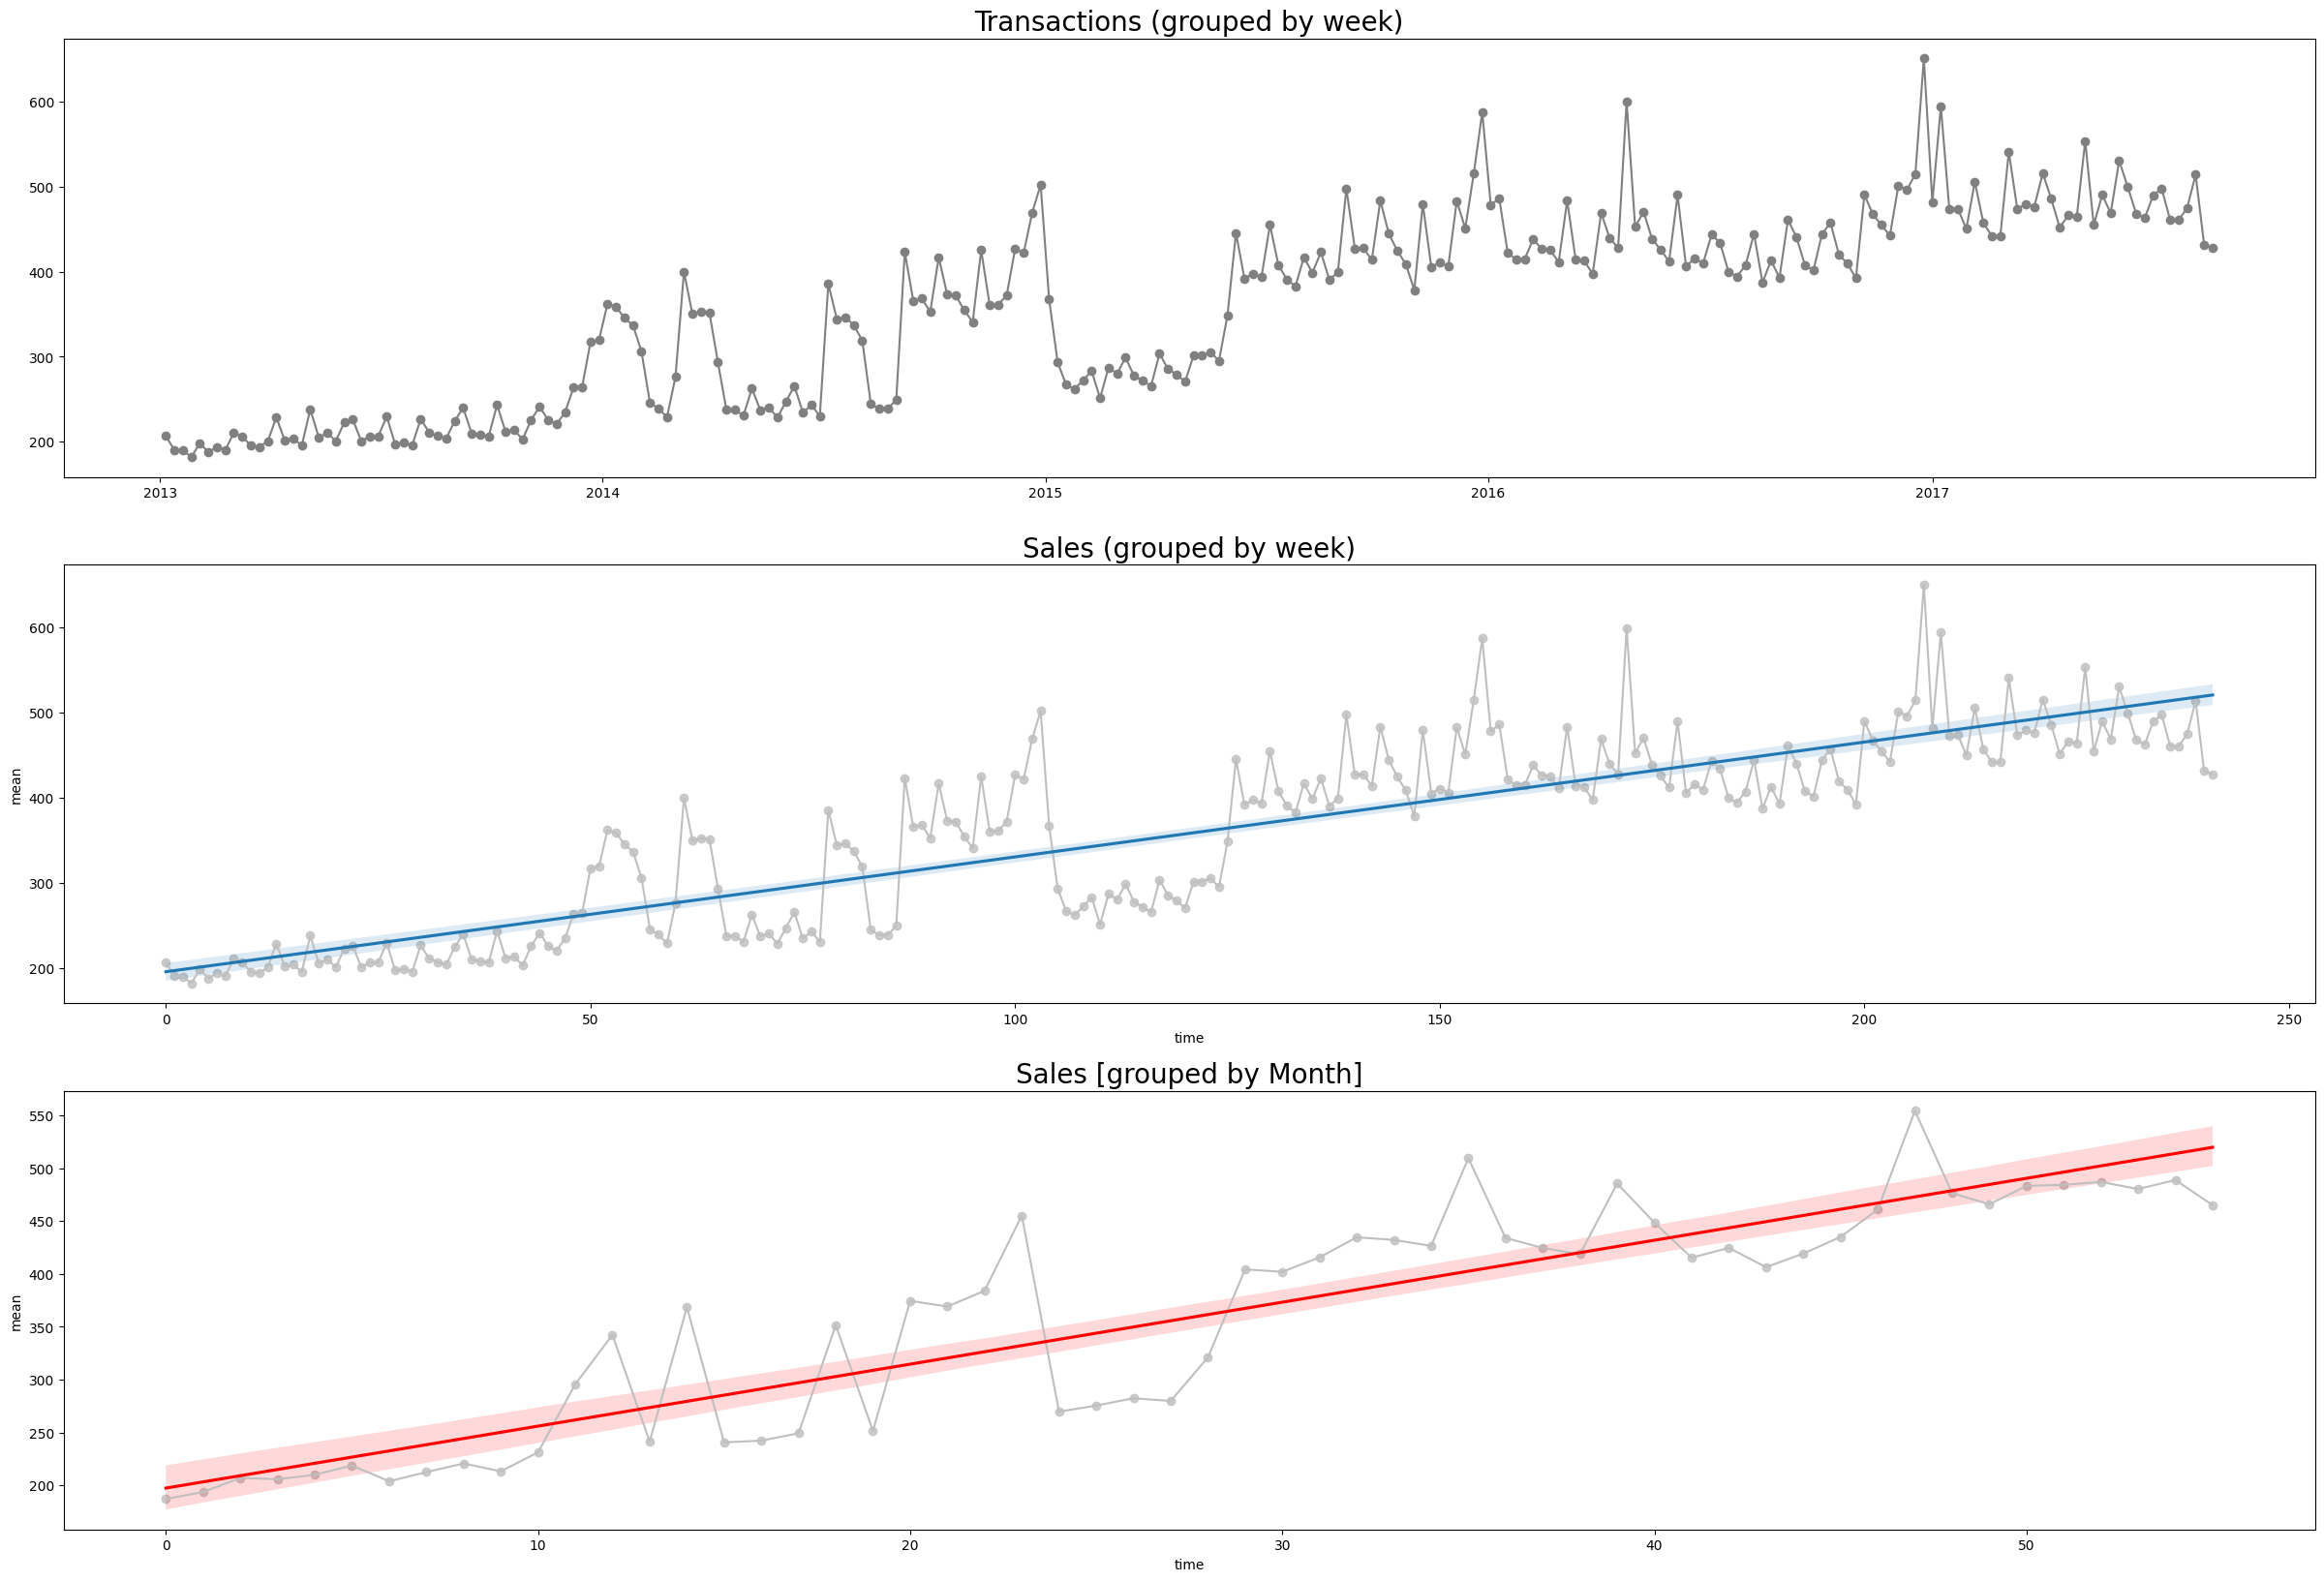

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# Transactions(weekly)
axes[0].plot('date', 'mean', data=df_grouped_train_w, color='grey', marker='o')
axes[0].set_title("Transactions (grouped by week)", fontsize=20)

# Sales (weekly)
axes[1].plot('time', 'mean', data=df_grouped_train_w, color='0.75')
axes[1].set_title('Sales (grouped by week)', fontsize=20)

# Linear regression
axes[1] = sns.regplot(x='time',
                     y='mean',
                     data = df_grouped_train_w,
                     scatter_kws = dict(color='0.75'),
                     ax = axes[1])

# Sales (Monthly)
axes[2].plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes[2].set_title('Sales [grouped by Month]', fontsize=20)

# Linear Regression
axes[2] = sns.regplot(x='time',
                     y = 'mean',
                     data = df_grouped_train_m,
                     scatter_kws = dict(color='0.75'),
                     line_kws={"color": "red"},
                     ax = axes[2])

plt.show()

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# 데이터 전처리
train_data = df_train.copy().drop(['onpromotion'], axis=1)
test_data = df_test.copy().drop(['onpromotion'], axis=1)
ordinal_encoder = OrdinalEncoder(dtype=int)
train_data[['family']] = ordinal_encoder.fit_transform(train_data[['family']])
test_data[['family']] = ordinal_encoder.transform(test_data[['family']])

# 데이터 통계 출력
n_o_days_train = train_data["date"].nunique(dropna=False)
print('number of days train:', n_o_days_train)
n_o_stores_train = train_data["store_nbr"].nunique(dropna=False)
print('number of stores train:', n_o_stores_train)
n_o_families_train = train_data["family"].nunique(dropna=False)
print('number of family/type of product train:', n_o_families_train)
n_o_days_test = test_data["date"].nunique(dropna=False)
print('number of days test:', n_o_days_test)
n_o_stores_test = test_data["store_nbr"].nunique(dropna=False)
print('number of stores test:', n_o_stores_test)
n_o_families_test = test_data["family"].nunique(dropna=False)

# 피벗 테이블 생성
pivoted_train = train_data.pivot(index=['date'], columns=['store_nbr', 'family'], values='sales')

# 데이터 분할
train_samples = int(n_o_days_train * 0.8)  # 80%를 훈련 데이터로 사용
train_samples_df = pivoted_train[:train_samples]
valid_samples_df = pivoted_train[train_samples:]

# 데이터 스케일링
minmax = MinMaxScaler()
minmax.fit(train_samples_df)

scaled_train_samples = minmax.transform(train_samples_df)
scaled_val_samples = minmax.transform(valid_samples_df)

# 데이터 형태 출력
print('scaled_train_samples shape:', scaled_train_samples.shape)
print('scaled_val_samples shape:', scaled_val_samples.shape)

# 단순한 시계열 데이터 분할 예시
n_past = 16
n_future = 16
n_features = n_o_stores_train * n_o_families_train

# 데이터 나누기
X_train = []
y_train = []
for i in range(n_past, len(scaled_train_samples) - n_future):
    X_train.append(scaled_train_samples[i - n_past:i])
    y_train.append(scaled_train_samples[i:i + n_future])

X_val = []
y_val = []
for i in range(n_past, len(scaled_val_samples) - n_future):
    X_val.append(scaled_val_samples[i - n_past:i])
    y_val.append(scaled_val_samples[i:i + n_future])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)

number of days train: 1684
number of stores train: 54
number of family/type of product train: 33
number of days test: 16
number of stores test: 54
scaled_train_samples shape: (1347, 1782)
scaled_val_samples shape: (337, 1782)
X_train.shape: (1315, 16, 1782)
y_train.shape: (1315, 16, 1782)
X_val.shape: (305, 16, 1782)
y_val.shape: (305, 16, 1782)


In [87]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.layers import Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(LSTM(units=256, return_sequences=True,input_shape=[n_past, n_features]))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
#TimeDistributed layer
model.add(TimeDistributed(Dense(n_features)))

model.compile(loss="mae", optimizer=Adam(learning_rate=0.001), metrics=['mae'])
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_mae', 
                           min_delta=0.0001,
                           patience=100,
                           restore_best_weights=True)

epochs= 1000

model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs = epochs,
                          callbacks = [early_stop],
                          batch_size=512,
                          shuffle=True)


Epoch 1/1000
3/3 [==============================] - 2s 380ms/step - loss: 0.3617 - mae: 0.3617 - val_loss: 4.8905 - val_mae: 4.8905
Epoch 2/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.2850 - mae: 0.2850 - val_loss: 4.8843 - val_mae: 4.8843
Epoch 3/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.2519 - mae: 0.2519 - val_loss: 4.8852 - val_mae: 4.8852
Epoch 4/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.2432 - mae: 0.2432 - val_loss: 4.8817 - val_mae: 4.8817
Epoch 5/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.2337 - mae: 0.2337 - val_loss: 4.8780 - val_mae: 4.8780
Epoch 6/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.2253 - mae: 0.2253 - val_loss: 4.8781 - val_mae: 4.8781
Epoch 7/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.2175 - mae: 0.2175 - val_loss: 4.8791 - val_mae: 4.8791
Epoch 8/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.2115 - 

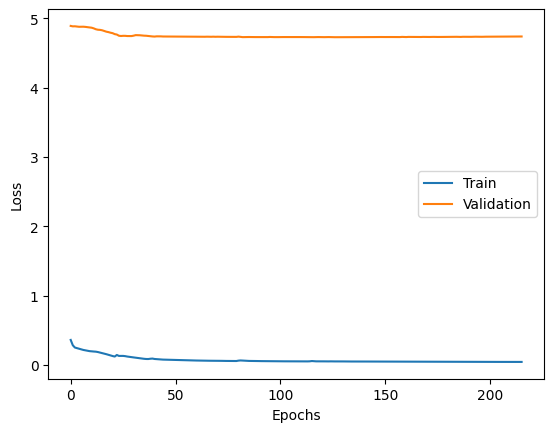

In [88]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_mae'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

In [89]:
initial_test_window = scaled_train_samples[-n_past:]
scaled_test_samples = minmax.transform(test_data.pivot(index=['date'], columns=['store_nbr', 'family'], values='id'))

# Generate test sequences
X_test, _ = split_series(np.vstack([initial_test_window, scaled_test_samples]), n_past, 0)

# Predict with the model
predictions = model.predict(X_test)

# Reshape predictions to original shape
predictions = predictions.reshape((predictions.shape[0], n_future, n_features))

# Rescale predictions back to original scale
predictions = minmax.inverse_transform(predictions.reshape(predictions.shape[0] * predictions.shape[1], n_features))
predictions = predictions.reshape((predictions.shape[0] // n_future, n_future, n_features))

# Prepare the submission dataframe
submission = pd.read_csv('data/sample_submission.csv')

for day_ith, day_ith_pred in enumerate(predictions):
    for n_samples_per_day in range(len(day_ith_pred)):
        sample_id = test_data.iloc[day_ith * n_future + n_samples_per_day]['id']
        values = max(0, day_ith_pred[n_samples_per_day].mean())  # Using mean to reduce array to single value
        submission.at[day_ith * n_future + n_samples_per_day, 'id'] = sample_id
        submission.at[day_ith * n_future + n_samples_per_day, 'sales'] = values

# Fill missing 'id' values in submission
submission['id'] = test_data['id']
submission['sales'] = submission['sales'].fillna(0)
submission = submission.dropna(subset=['id'])

# Display the submission dataframe
print(submission)

1/1 [==============================] - 0s 278ms/step
            id       sales
0      3000888  358.490265
1      3000889  369.470337
2      3000890  374.537384
3      3000891  369.984650
4      3000892  385.423065
...        ...         ...
28507  3029395    0.000000
28508  3029396    0.000000
28509  3029397    0.000000
28510  3029398    0.000000
28511  3029399    0.000000

[28512 rows x 2 columns]


In [78]:
submission.to_csv('for_submission.csv', index=False)

In [ ]:
X_train_pred = scaled_train_samples[-n_past:,:].reshape((1, n_past, n_features))
print(X_train_pred.shape)
scaled_train_predict = model.predict(X_test_pred)

(1, 16, 1782)
1/1 [==============================] - 0s 10ms/step


In [ ]:
# Inverse transform from the previous min max scaler
y_predict = pd.DataFrame(minmax.inverse_transform(scaled_test_predict.reshape((n_future, n_features))),columns=valid_samples_df.columns)

In [ ]:
scaled_train_predict

array([[[ 0.19135082, -0.00247961,  0.27002782, ...,  0.3354125 ,
          0.01074952,  0.24704447],
        [ 0.17483446, -0.0023213 ,  0.24854356, ...,  0.3757033 ,
          0.00917342,  0.26905456],
        [ 0.189724  , -0.00336374,  0.24636437, ...,  0.38153702,
          0.00913028,  0.2570529 ],
        ...,
        [ 0.20623645, -0.00234417,  0.2619102 , ...,  0.4021733 ,
          0.01183717,  0.2298252 ],
        [ 0.20033573, -0.00228754,  0.2572196 , ...,  0.31500113,
          0.01105356,  0.22286355],
        [ 0.2041233 , -0.00247877,  0.27130383, ...,  0.4005341 ,
          0.01356456,  0.28572717]]], dtype=float32)

In [ ]:
pivoted_test = test_data.pivot(index=['date'], columns=['store_nbr', 'family'])
pivoted_test

id                                                        \
store_nbr         1                                                         
family           0        1        2        3        4        5        6    
date                                                                        
2017-08-16  3000888  3000889  3000890  3000891  3000892  3000893  3000894   
2017-08-17  3002670  3002671  3002672  3002673  3002674  3002675  3002676   
2017-08-18  3004452  3004453  3004454  3004455  3004456  3004457  3004458   
2017-08-19  3006234  3006235  3006236  3006237  3006238  3006239  3006240   
2017-08-20  3008016  3008017  3008018  3008019  3008020  3008021  3008022   
2017-08-21  3009798  3009799  3009800  3009801  3009802  3009803  3009804   
2017-08-22  3011580  3011581  3011582  3011583  3011584  3011585  3011586   
2017-08-23  3013362  3013363  3013364  3013365  3013366  3013367  3013368   
2017-08-24  3015144  3015145  3015146  3015147  3015148  3015149  3015150   
2017-08-25  3016926  3016927  3016928  3016929  3016930  3016931  3016932   
2017-08-26  3018708  3018709  3018710  3018711  3018712  3018713  3018714   
2017-08-27  3020490  3020491  3020492  3020493  3020494  3020495  3020496   
2017-08-28  3022272  3022273  3022274  3022275  3022276  3022277  3022278   
2017-08-29  3024054  3024055  3024056  3024057  3024058  3024059  3024060   
2017-08-30  3025836  3025837  3025838  3025839  3025840  3025841  3025842   
2017-08-31  3027618  3027619  3027620  3027621  3027622  3027623  3027624   

                                       ...                             \
store_nbr                              ...        9                     
family           7        8        9   ...       23       24       25   
date                                   ...                              
2017-08-16  3000895  3000896  3000897  ...  3002660  3002661  3002662   
2017-08-17  3002677  3002678  3002679  ...  3004442  3004443  3004444   
2017-08-18  3004459  3004460  3004461  ...  3006224  3006225  3006226   
2017-08-19  3006241  3006242  3006243  ...  3008006  3008007  3008008   
2017-08-20  3008023  3008024  3008025  ...  3009788  3009789  3009790   
2017-08-21  3009805  3009806  3009807  ...  3011570  3011571  3011572   
2017-08-22  3011587  3011588  3011589  ...  3013352  3013353  3013354   
2017-08-23  3013369  3013370  3013371  ...  3015134  3015135  3015136   
2017-08-24  3015151  3015152  3015153  ...  3016916  3016917  3016918   
2017-08-25  3016933  3016934  3016935  ...  3018698  3018699  3018700   
2017-08-26  3018715  3018716  3018717  ...  3020480  3020481  3020482   
2017-08-27  3020497  3020498  3020499  ...  3022262  3022263  3022264   
2017-08-28  3022279  3022280  3022281  ...  3024044  3024045  3024046   
2017-08-29  3024061  3024062  3024063  ...  3025826  3025827  3025828   
2017-08-30  3025843  3025844  3025845  ...  3027608  3027609  3027610   
2017-08-31  3027625  3027626  3027627  ...  3029390  3029391  3029392   

                                                                           
store_nbr                                                                  
family           26       27       28       29       30       31       32  
date                                                                       
2017-08-16  3002663  3002664  3002665  3002666  3002667  3002668  3002669  
2017-08-17  3004445  3004446  3004447  3004448  3004449  3004450  3004451  
2017-08-18  3006227  3006228  3006229  3006230  3006231  3006232  3006233  
2017-08-19  3008009  3008010  3008011  3008012  3008013  3008014  3008015  
2017-08-20  3009791  3009792  3009793  3009794  3009795  3009796  3009797  
2017-08-21  3011573  3011574  3011575  3011576  3011577  3011578  3011579  
2017-08-22  3013355  3013356  3013357  3013358  3013359  3013360  3013361  
2017-08-23  3015137  3015138  3015139  3015140  3015141  3015142  3015143  
2017-08-24  3016919  3016920  3016921  3016922  3016923  3016924  3016925  
2017-08-25  3018701  301870

In [ ]:
test_data

,id,date,store_nbr,family
0,3000888,2017-08-16,1,0
1,3000889,2017-08-16,1,1
2,3000890,2017-08-16,1,2
3,3000891,2017-08-16,1,3
4,3000892,2017-08-16,1,4
...,...,...,...,...
28507,3029395,2017-08-31,9,28
28508,3029396,2017-08-31,9,29
28509,3029397,2017-08-31,9,30
28510,3029398,2017-08-31,9,31


In [ ]:
pivoted_test.values

(16, 1782)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
submission['sales'] = pivoted_test['id']

ValueError: Columns must be same length as key

In [ ]:
submission.to_csv('for_submission.csv', index=False)

In [ ]:
https://www.kaggle.com/code/karan842/store-sales-forecasting-eda-lstm